In [65]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from databases.sql_connect import create_connection
import numpy as np
import os
import sys
parent = os.path.realpath(os.path.join(os.path.abspath(''), os.pardir))
sys.path.append(parent)

_point = "\u00b7"

sns.set_theme()
sns.set(context="paper", style="darkgrid", font="Times New Roman")
cm = 1/2.54
DB_CORR = os.path.join(parent, "databases", "TEMPRO_DB230416_Corr.db")
assert(os.path.exists(DB_CORR))
FONTSIZE = 8

cats = {"CED - total": "CED",
        "CExD - metals": "CExD",
        "ADP": "ADP",
        "EI-Minerals- Total": "ADP\nEI",
        "GPR-Minerals- Total": "GPSR",
        "CML-climate change (GWP 100a)": "GWP",
        "ReCiPe Midpoint (E) - metal depletion (MDP)": "MDP",
        "ReCiPe Endpoint (E - A) - total (total)": "Total",
        }

full_label = {
    'CED': 'Primary Energy Demand [MJ-eq]',
    'CExD': 'Primary Exergy Demand [MJ-eq]',
    'ADP': 'Abiotic Depletion Potential [kg Sb-eq]',
    'ADP\nEI': 'ADP - Economic Importance [kg Sb-eq]',
    'GPSR': 'Geo-Political Suppy Risk [1]',
    'GWP': 'Greenhouse Emissions [kg CO2-eq]',
    'MDP': 'Metal Depletion Potential [kg Fe-eq]',
    'Total': 'ReCiPe-Total Impacts',
}


In [66]:
def get_impacts_by_cat(group= 4000):
    conn = create_connection(DB_CORR)
    query = f'SELECT * FROM [{group}LCAResults]'
    df_lca = pd.read_sql_query(query, conn)
    conn.close()
    df_ = []
    for cat in cats.keys():
        df = df_lca[df_lca["Category"] == cat]
        df.set_index("ProductSystemID", inplace=True)
        df=df[["Result"]]
        df.columns=[cats[cat]]
        df_.append(df)
    df_impacts = pd.concat(df_,axis=1)
    df_impacts.rename(columns=cats)

    return df_impacts

def get_ps_info(group= 4000):
    conn = create_connection(DB_CORR)
    table_name = {2000:"2000Parts",
                  3000:"3000Pieces",
                  4000:"4000Devices",
                5000:"5000Systems",
                                6000:"6000DataCenters"}
    query = f'SELECT * FROM [{table_name[group]}]'
    df_ps = pd.read_sql_query(query, conn)
    conn.close() 
    df_ps.set_index("ID", inplace=True)
    return df_ps

In [67]:
# Get all exchanges for 600x
dc_id = 6024

# Get all exchanges for each 5000 in the xchanges
conn = create_connection(DB_CORR)
query = f'SELECT * FROM [6000Exchanges] where "6000ID"={dc_id}'
df_lca = pd.read_sql_query(query, conn)
df_lca.set_index("5000Systems",)
conn.close()

df_5000_=[]
for id_5000 in df_lca["5000Systems"]:

    conn = create_connection(DB_CORR)
    query = f'SELECT * FROM [5000Exchanges] where "5000ID"={id_5000}'
    df_lci_5000 = pd.read_sql_query(query, conn)
    conn.close()
    df_5000_.append(df_lci_5000)

df_exch = pd.concat(df_5000_)
df_exch.reset_index(inplace=True)
#df_exch.fillna("0")
df_exch.head()

,index,ID,5000ID,5000Name,2000Parts,3000Pieces,4000Devices,ExchangeName,Amount,Unit,StandardDev,DataQuality
0,0,1178,5124,KDO-IT,,,4401,Blade Server 1U,1123.902,kg,1.062245,(1;2;2;1;3)
1,1,1179,5124,KDO-IT,,,4404,Blade Server 2 Socket,509.915,kg,1.062245,(1;2;2;1;3)
2,2,1180,5124,KDO-IT,,,4432,"Server 4U, no storage",812.940,kg,1.062245,(1;2;2;1;3)
3,3,1181,5124,KDO-IT,,,4433,"Server 5U, no storage",70.740,kg,1.062245,(1;2;2;1;3)
4,4,1182,5124,KDO-IT,,,4417,HDD,186.186,kg,1.062245,(1;2;2;1;3)


In [68]:


# Get all the impact results for the 4000s and 3000s
df_4000_lci=get_impacts_by_cat(4000)
df_3000_lci=get_impacts_by_cat(3000)
df_2000_lci=get_impacts_by_cat(2000)
# Multiply the impacts for the contents and for the factors

df_2000_info = get_ps_info(2000)
df_3000_info = get_ps_info(3000)
df_4000_info = get_ps_info(4000)
df_5000_info = get_ps_info(5000)
df_6000_info = get_ps_info(6000)

In [69]:

df_exch["RefVal"] = np.nan
df_exch["LT"] = np.nan
df_exch["IDe"] = np.nan
# put the ref amount info
for idx, rows in df_exch.iterrows():
    try:
        if int(rows["2000Parts"]) > 2000:
            df_exch.at[idx, "RefVal"] = df_2000_info.at[rows["2000Parts"], "Amount"]
            df_exch.at[idx, "LT"] = 20
            df_exch.at[idx, "IDe"] = int(rows["2000Parts"])

    except:
        pass
    try:
        if int(rows["3000Pieces"]) > 3000:
            df_exch.at[idx, "RefVal"] = df_3000_info.at[rows["3000Pieces"], "Amount"]
            df_exch.at[idx, "LT"] = df_3000_info.at[rows["3000Pieces"], "Lifetime"]
            df_exch.at[idx, "IDe"] = int(rows["3000Pieces"])

    except:
        pass

    try:
        if int(rows["4000Devices"]) > 4000:
            df_exch.at[idx, "RefVal"] = df_4000_info.at[rows["4000Devices"], "Amount"]
            df_exch.at[idx, "LT"] = df_4000_info.at[rows["4000Devices"], "Lifetime"]
            df_exch.at[idx, "IDe"] = int(rows["4000Devices"])
    except:
        pass

df_exch_ID =df_exch[['IDe',"5000ID",'ExchangeName', 'Amount', 'Unit', 'RefVal', 'LT']] 

df_exch_ID
for k,v in full_label.items():
    df_exch_ID[k]= np.nan
df_exch_ID["Group"]= np.nan
df_exch_ID.set_index("IDe", inplace=True)


C:\Users\fpenaherrera_vaca\AppData\Local\Temp\ipykernel_26744\2092819765.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_exch_ID[k]= np.nan
C:\Users\fpenaherrera_vaca\AppData\Local\Temp\ipykernel_26744\2092819765.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_exch_ID[k]= np.nan
C:\Users\fpenaherrera_vaca\AppData\Local\Temp\ipykernel_26744\2092819765.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = va

In [72]:
# This Is NOT ANNUALIZED
import copy
df_exch_ID_total = copy.deepcopy(df_exch_ID)

for idx,row in df_exch_ID_total.iterrows():
    df_exch_ID_total.at[idx,"Group"] = df_5000_info.at[row["5000ID"],"5000CategoryName"]
    ref_val = row["RefVal"]
    amount = row["Amount"]
    lifetime =row["LT"]
    if 2000<=idx<3000:
        for k,v in full_label.items():
            df_exch_ID_total.at[idx,k] = df_2000_lci.at[idx,k]/ ref_val*amount
    
    elif 3000<=idx<4000:
        for k,v in full_label.items():
            df_exch_ID_total.at[idx,k] = df_3000_lci.at[idx,k]/ ref_val*amount
    else:
        for k,v in full_label.items():
            try:
                df_exch_ID_total.at[idx,k] = df_4000_lci.at[idx,k]/ ref_val*amount
            except:
                df_exch_ID_total.at[idx,k]=0
df_exch_ID_total.head()

,5000ID,ExchangeName,Amount,Unit,RefVal,LT,CED,CExD,ADP,ADP\nEI,GPSR,GWP,MDP,Total,Group
IDe,,,,,,,,,,,,,,,
4401.0,5124,Blade Server 1U,1123.902,kg,9.606,5.0,1.074611e+06,325977.264357,586.026155,196.514090,1.898212e+09,70245.544822,23706.820864,39956.212610,IT
4404.0,5124,Blade Server 2 Socket,509.915,kg,5.999,5.0,6.656530e+05,251960.575436,363.626234,128.749197,1.362005e+09,43168.893379,17570.090050,29685.576046,IT
4432.0,5124,"Server 4U, no storage",812.940,kg,47.820,5.0,4.375743e+05,202756.929132,251.734011,100.486986,1.045063e+09,29292.913363,14746.114141,21926.950595,IT
4433.0,5124,"Server 5U, no storage",70.740,kg,70.740,5.0,3.896521e+04,39238.546276,22.784678,10.621878,1.986342e+08,2606.348143,1272.780741,1990.128366,IT
4417.0,5124,HDD,186.186,kg,1.001,3.0,4.312440e+04,35943.742401,28.840853,13.640904,1.873453e+08,3164.800036,-355.981320,2686.445970,IT


In [73]:
# This Annualizes the values
import copy
df_exch_ID_annual = copy.deepcopy(df_exch_ID)

for idx,row in df_exch_ID_annual.iterrows():
    df_exch_ID_annual.at[idx,"Group"] = df_5000_info.at[row["5000ID"],"5000CategoryName"]
    ref_val = row["RefVal"]
    amount = row["Amount"]
    lifetime =row["LT"]
    if 2000<=idx<3000:
        for k,v in full_label.items():
            df_exch_ID_annual.at[idx,k] = df_2000_lci.at[idx,k]/ ref_val*amount/lifetime
    
    elif 3000<=idx<4000:
        for k,v in full_label.items():
            df_exch_ID_annual.at[idx,k] = df_3000_lci.at[idx,k]/ ref_val*amount/lifetime
    else:
        for k,v in full_label.items():
            try:
                df_exch_ID_annual.at[idx,k] = df_4000_lci.at[idx,k]/ ref_val*amount/lifetime
            except:
                df_exch_ID_annual.at[idx,k]=0
df_exch_ID_annual.head()

,5000ID,ExchangeName,Amount,Unit,RefVal,LT,CED,CExD,ADP,ADP\nEI,GPSR,GWP,MDP,Total,Group
IDe,,,,,,,,,,,,,,,
4401.0,5124,Blade Server 1U,1123.902,kg,9.606,5.0,214922.151247,65195.452871,117.205231,39.302818,3.796425e+08,14049.108964,4741.364173,7991.242522,IT
4404.0,5124,Blade Server 2 Socket,509.915,kg,5.999,5.0,133130.591244,50392.115087,72.725247,25.749839,2.724009e+08,8633.778676,3514.018010,5937.115209,IT
4432.0,5124,"Server 4U, no storage",812.940,kg,47.820,5.0,87514.857532,40551.385826,50.346802,20.097397,2.090125e+08,5858.582673,2949.222828,4385.390119,IT
4433.0,5124,"Server 5U, no storage",70.740,kg,70.740,5.0,7793.042825,7847.709255,4.556936,2.124376,3.972684e+07,521.269629,254.556148,398.025673,IT
4417.0,5124,HDD,186.186,kg,1.001,3.0,14374.799849,11981.247467,9.613618,4.546968,6.244843e+07,1054.933345,-118.660440,895.481990,IT


In [74]:
def create_stacked_plot(df_exch_ID_annual, ax = None):
    df_annual = copy.deepcopy(df_exch_ID_annual)
    df_annual2= df_annual.groupby('Group').sum()

    columns= [c for c in full_label.keys() ]
    df_annual2=df_annual2[columns]
    df_annual2=df_annual2.transpose()

    sum = df_annual2.sum(axis=1)
    for idx, row in df_annual2.iterrows():
        for c in df_annual2.columns:
            df_annual2.at[idx,c] = df_annual2.at[idx,c]/sum[idx]

    df_annual2
    df_annual2.plot.barh(stacked=True, ax=ax)
    return None

C:\Users\fpenaherrera_vaca\AppData\Local\Temp\ipykernel_26744\1628889363.py:3: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_annual2= df_annual.groupby('Group').sum()
C:\Users\fpenaherrera_vaca\AppData\Local\Temp\ipykernel_26744\1628889363.py:3: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_annual2= df_annual.groupby('Group').sum()


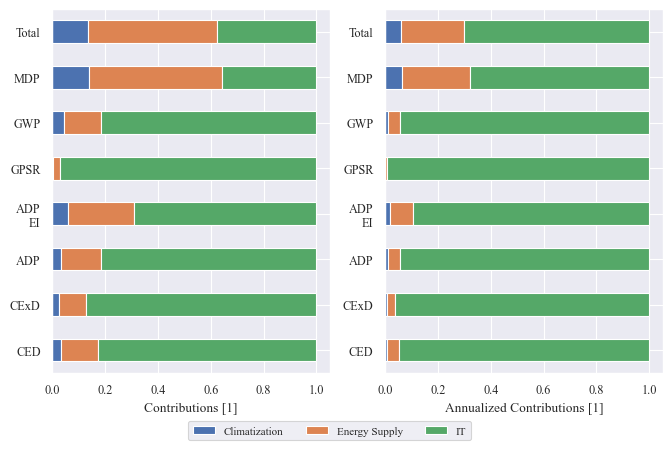

In [75]:
fig, axs = plt.subplots(1, 2, figsize=(20*cm,12*cm))
create_stacked_plot(df_exch_ID_total, axs[0])
create_stacked_plot(df_exch_ID_annual, ax=axs[1])

for i in range(0, 2):
    ax = axs[i]
    if i == 0:
        ax.get_legend().remove()
        ax.set_xlabel("Contributions [1]")
    if i == 1:
        ax.legend(bbox_to_anchor=(-0.2, -0.2),
                  loc="lower center", fontsize=FONTSIZE, ncols=4)
        ax.set_xlabel("Annualized Contributions [1]")
fig.savefig(f"ContributionBars/annual_compar_{dc_id}.png",bbox_inches='tight',dpi=600)